In [1]:
import pandas as pd 
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors

In [2]:
from read_wandb import wandb_results
api = wandb_results("Strategy_Transfer_TACL")

BASE_METRIC = "accuracy_per_mean_user_and_bot"

In [3]:
def result_metric(sweeps, group_name, drop_list=[], drop_HPT=False, metric=BASE_METRIC, epoch="best", default=False):
    df = api.get_sweeps_results(sweeps, metric=metric) 

    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    if default:
        HPT_cols = [col for col in config_cols if df[col].nunique() > 1]
    else:
        HPT_cols = ["config_seed", "config_final_change"]
        df["config_final_change"] = df["config_final_change"].replace("none", 0)


    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]
    
    # Remove non-numeric columns before computing mean and std
    numeric_cols = df.select_dtypes(include=np.number).columns
    df_numeric = df[[*numeric_cols, 'config_final_change']]

    grouped = df_numeric.groupby([c for c in HPT_cols if c != "config_seed"])

    mean_df = grouped.mean()
    std_df = grouped.std()
    
    # Re-add non-numeric columns before computing best_col
    for col in config_cols:
        if col not in mean_df.columns:
            mean_df[col] = df[col]

    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)

    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())


    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best": df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))

    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


# For HyperParameterTuning

For every configuration that you test in the sweep, you will receive in the table the average, standard deviation, all the values obtained for the different seed values, and also the confidence interval within which the result is located at a confidence level of 95%.

When epoch="best" is defined, you can check in which epoch the best result is obtained. If epoch=5 is defined, you will receive the result obtained for epoch number 5.

You can test multiple sweeps simultaneously by entering them into the list found in the first element of the function result_metric.

In [4]:
# Create the directory if it doesn't exist
directory = 'sweeps_csvs'
if not os.path.exists(directory):
    os.makedirs(directory)

# Result for a specific epoch

In [6]:
results_per_epoch = [[], [], []]
for epoch in range(25):
    sweep_results = result_metric(["64gkgssh"], "Final Change", drop_HPT=False, epoch=epoch)
    for i, row in sweep_results.iterrows():
        results_per_epoch[int(i)].append(row["mean"])


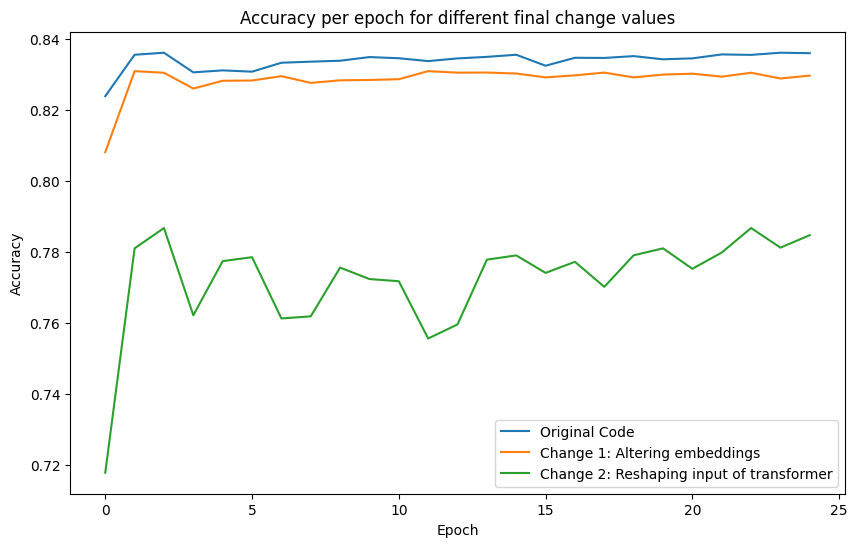

In [7]:
# Show results per epoch for all three of the final change values
plt.figure(figsize=(10, 6))
plt.plot(results_per_epoch[0], label="Original Code")
plt.plot(results_per_epoch[1], label="Change 1: Altering embeddings")
plt.plot(results_per_epoch[2], label="Change 2: Reshaping input of transformer")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch for different final change values")
plt.legend()
plt.show()

In [8]:
sweep_results = result_metric(["64gkgssh"], "Final Change", drop_HPT=False, epoch="best")

sweep_results.rename(index={0: "Original Code", "1": "Change 1: Altering embeddings", "2": "Change 2: Reshaping input of transformer"}, inplace=True)
sweep_results = sweep_results.drop("values", axis=1)
sweep_results = sweep_results.drop("epoch", axis=1)

sweep_results

,mean,std,CI
Final Change,,,
Original Code,0.836174,0.001493,"(0.8350851189562978, 0.8372764584012267)"
Change 1: Altering embeddings,0.830979,0.003834,"(0.8278224562579275, 0.8337331602459515)"
Change 2: Reshaping input of transformer,0.786734,0.005048,"(0.7821872467736726, 0.7904951192594981)"
